In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [2]:
# データの読み込み
print("データを読み込み中...")

# Fama-French 3ファクターデータ（日次）
ff_data = pd.read_csv('../data/F-F_Research_Data_Factors_daily.csv')
print(f"Fama-French データ: {ff_data.shape}")
print(ff_data.head())

# ドル円レート（月次）
fx_data = pd.read_csv('../data/nme_R031.461815.20250704110210.01.csv')
print(f"\nドル円レート データ: {fx_data.shape}")
print(fx_data.head())

# 日本の短期国債利回り（日次）
jpy_yield_data = pd.read_csv('../data/GTJPY3M_Govt_short-term_Treasury_yield.csv')
print(f"\n日本短期国債利回り データ: {jpy_yield_data.shape}")
print(jpy_yield_data.head())


データを読み込み中...
Fama-French データ: (25982, 5)
       DATE  MKT-RF   SMB   HML     RF
0  19260701    0.09 -0.25 -0.27  0.009
1  19260702    0.45 -0.33 -0.06  0.009
2  19260706    0.17  0.30 -0.39  0.009
3  19260707    0.09 -0.58  0.02  0.009
4  19260708    0.22 -0.38  0.19  0.009

ドル円レート データ: (630, 2)
      DATE  JPY/USD
0  1973/01   301.15
1  1973/02   270.00
2  1973/03   265.83
3  1973/04   265.50
4  1973/05   264.95

日本短期国債利回り データ: (3159, 4)
         DATE  PX_LAST  YLD_YTM_MYLD  YTM_BID
0  2010/01/04    0.137         0.137    0.137
1  2010/01/05    0.138         0.138    0.138
2  2010/01/06    0.141         0.141    0.141
3  2010/01/07    0.137         0.137    0.137
4  2010/01/08    0.136         0.136    0.136


In [3]:
# データの前処理
print("\nデータの前処理を開始...")

# Fama-French データの日付形式を変換
ff_data['DATE'] = pd.to_datetime(ff_data['DATE'], format='%Y%m%d')
ff_data.set_index('DATE', inplace=True)

# リターンを小数に変換（%表記なので100で割る）
ff_data[['MKT-RF', 'SMB', 'HML', 'RF']] = ff_data[['MKT-RF', 'SMB', 'HML', 'RF']] / 100

# ドル円レートの日付形式を変換
fx_data['DATE'] = pd.to_datetime(fx_data['DATE'], format='%Y/%m')
fx_data.set_index('DATE', inplace=True)

# 日本の短期国債利回りの日付形式を変換
jpy_yield_data['DATE'] = pd.to_datetime(jpy_yield_data['DATE'], format='%Y/%m/%d')
jpy_yield_data.set_index('DATE', inplace=True)

# 利回りを小数に変換（%表記なので100で割る）
jpy_yield_data['YLD_YTM_MYLD'] = jpy_yield_data['YLD_YTM_MYLD'] / 100

print("前処理完了")
print(f"Fama-French データ期間: {ff_data.index.min()} から {ff_data.index.max()}")
print(f"ドル円レート データ期間: {fx_data.index.min()} から {fx_data.index.max()}")
print(f"日本短期国債利回り データ期間: {jpy_yield_data.index.min()} から {jpy_yield_data.index.max()}")



データの前処理を開始...
前処理完了
Fama-French データ期間: 1926-07-01 00:00:00 から 2025-04-30 00:00:00
ドル円レート データ期間: 1973-01-01 00:00:00 から 2025-06-01 00:00:00
日本短期国債利回り データ期間: 2010-01-04 00:00:00 から 2024-12-05 00:00:00


In [4]:
# 月次データへの変換
print("\n月次データへの変換を開始...")

# Fama-French データを月次に変換（月末の値を取得）
ff_monthly = ff_data.resample('M').last()

# 日本の短期国債利回りを月次に変換（月末の値を取得）
jpy_yield_monthly = jpy_yield_data['YLD_YTM_MYLD'].resample('M').last()

# ドル円レートは既に月次データ

print("月次変換完了")
print(f"月次Fama-French データ: {ff_monthly.shape}")
print(f"月次日本短期国債利回り データ: {jpy_yield_monthly.shape}")
print(f"月次ドル円レート データ: {fx_data.shape}")



月次データへの変換を開始...
月次変換完了
月次Fama-French データ: (1186, 4)
月次日本短期国債利回り データ: (180,)
月次ドル円レート データ: (630, 1)


In [5]:
# データの結合
print("\nデータの結合を開始...")

# 共通の期間でデータを結合
start_date = max(ff_monthly.index.min(), fx_data.index.min(), jpy_yield_monthly.index.min())
end_date = min(ff_monthly.index.max(), fx_data.index.max(), jpy_yield_monthly.index.max())

print(f"結合期間: {start_date} から {end_date}")

# 各データを共通期間でフィルタリング
ff_filtered = ff_monthly[(ff_monthly.index >= start_date) & (ff_monthly.index <= end_date)]
fx_filtered = fx_data[(fx_data.index >= start_date) & (fx_data.index <= end_date)]
jpy_yield_filtered = jpy_yield_monthly[(jpy_yield_monthly.index >= start_date) & (jpy_yield_monthly.index <= end_date)]

# データを結合
combined_data = pd.DataFrame({
    'MKT_RF': ff_filtered['MKT-RF'],
    'SMB': ff_filtered['SMB'],
    'HML': ff_filtered['HML'],
    'RF_US': ff_filtered['RF'],
    'JPY_USD': fx_filtered['JPY/USD'],
    'JPY_YIELD': jpy_yield_filtered
})

# 欠損値を確認
print(f"\n結合後のデータ: {combined_data.shape}")
print("欠損値の確認:")
print(combined_data.isnull().sum())

# 欠損値を前方補完で処理
combined_data = combined_data.fillna(method='ffill')

print("データ結合完了")
print(combined_data.head())



データの結合を開始...
結合期間: 2010-01-31 00:00:00 から 2024-12-31 00:00:00

結合後のデータ: (359, 6)
欠損値の確認:
MKT_RF       179
SMB          179
HML          179
RF_US        179
JPY_USD      180
JPY_YIELD    179
dtype: int64
データ結合完了
            MKT_RF     SMB     HML  RF_US  JPY_USD  JPY_YIELD
DATE                                                         
2010-01-31 -0.0097 -0.0005 -0.0042    0.0      NaN    0.00126
2010-02-01 -0.0097 -0.0005 -0.0042    0.0    89.34    0.00126
2010-02-28  0.0012 -0.0056  0.0040    0.0    89.34    0.00136
2010-03-01  0.0012 -0.0056  0.0040    0.0    93.27    0.00136
2010-03-31 -0.0036 -0.0051  0.0020    0.0    93.27    0.00135


In [6]:
# 為替変動率の計算
print("\n為替変動率の計算を開始...")

# ドル円レートの変動率を計算
combined_data['FX_RETURN'] = combined_data['JPY_USD'].pct_change()

# 最初の行の為替変動率は0に設定
combined_data.loc[combined_data.index[0], 'FX_RETURN'] = 0

print("為替変動率計算完了")
print(combined_data[['JPY_USD', 'FX_RETURN']].head())



為替変動率の計算を開始...
為替変動率計算完了
            JPY_USD  FX_RETURN
DATE                          
2010-01-31      NaN   0.000000
2010-02-01    89.34        NaN
2010-02-28    89.34   0.000000
2010-03-01    93.27   0.043989
2010-03-31    93.27   0.000000


In [7]:
# 日本の短期国債利回りを月次ベースに変換
print("\n日本の短期国債利回りを月次ベースに変換...")

# 年率から月次ベースに変換（1/12乗根を取る）
combined_data['JPY_YIELD_MONTHLY'] = (1 + combined_data['JPY_YIELD']) ** (1/12) - 1

print("月次ベース変換完了")
print(combined_data[['JPY_YIELD', 'JPY_YIELD_MONTHLY']].head())



日本の短期国債利回りを月次ベースに変換...
月次ベース変換完了
            JPY_YIELD  JPY_YIELD_MONTHLY
DATE                                    
2010-01-31    0.00126           0.000105
2010-02-01    0.00126           0.000105
2010-02-28    0.00136           0.000113
2010-03-01    0.00136           0.000113
2010-03-31    0.00135           0.000112


In [8]:
# 3ファクターモデルのファクターリターン作成
print("\n3ファクターモデルのファクターリターンを作成...")

# 1. 元データからリスクフリーレートを加える（純粋なマーケットリターンを計算）
combined_data['MARKET_RETURN'] = combined_data['MKT_RF'] + combined_data['RF_US']

# 2. 為替調整を行う
combined_data['MARKET_RETURN_FX_ADJUSTED'] = combined_data['MARKET_RETURN'] * (1 + combined_data['FX_RETURN'])

# 3. 新しいリスクフリーレートを適用する
combined_data['MKT_RF_JPY'] = combined_data['MARKET_RETURN_FX_ADJUSTED'] - combined_data['JPY_YIELD_MONTHLY']

# 4. サイズファクターとバリューファクターも為替調整
combined_data['SMB_JPY'] = combined_data['SMB'] * (1 + combined_data['FX_RETURN'])
combined_data['HML_JPY'] = combined_data['HML'] * (1 + combined_data['FX_RETURN'])

# 5. リスクフリーレートを円ベースに設定
combined_data['RF_JPY'] = combined_data['JPY_YIELD_MONTHLY']

print("3ファクターモデル作成完了")
print(combined_data[['MKT_RF', 'MKT_RF_JPY', 'SMB', 'SMB_JPY', 'HML', 'HML_JPY', 'RF_US', 'RF_JPY']].head())



3ファクターモデルのファクターリターンを作成...
3ファクターモデル作成完了
            MKT_RF  MKT_RF_JPY     SMB   SMB_JPY     HML   HML_JPY  RF_US  \
DATE                                                                        
2010-01-31 -0.0097   -0.009805 -0.0005 -0.000500 -0.0042 -0.004200    0.0   
2010-02-01 -0.0097         NaN -0.0005       NaN -0.0042       NaN    0.0   
2010-02-28  0.0012    0.001087 -0.0056 -0.005600  0.0040  0.004000    0.0   
2010-03-01  0.0012    0.001140 -0.0056 -0.005846  0.0040  0.004176    0.0   
2010-03-31 -0.0036   -0.003712 -0.0051 -0.005100  0.0020  0.002000    0.0   

              RF_JPY  
DATE                  
2010-01-31  0.000105  
2010-02-01  0.000105  
2010-02-28  0.000113  
2010-03-01  0.000113  
2010-03-31  0.000112  



結果の可視化...


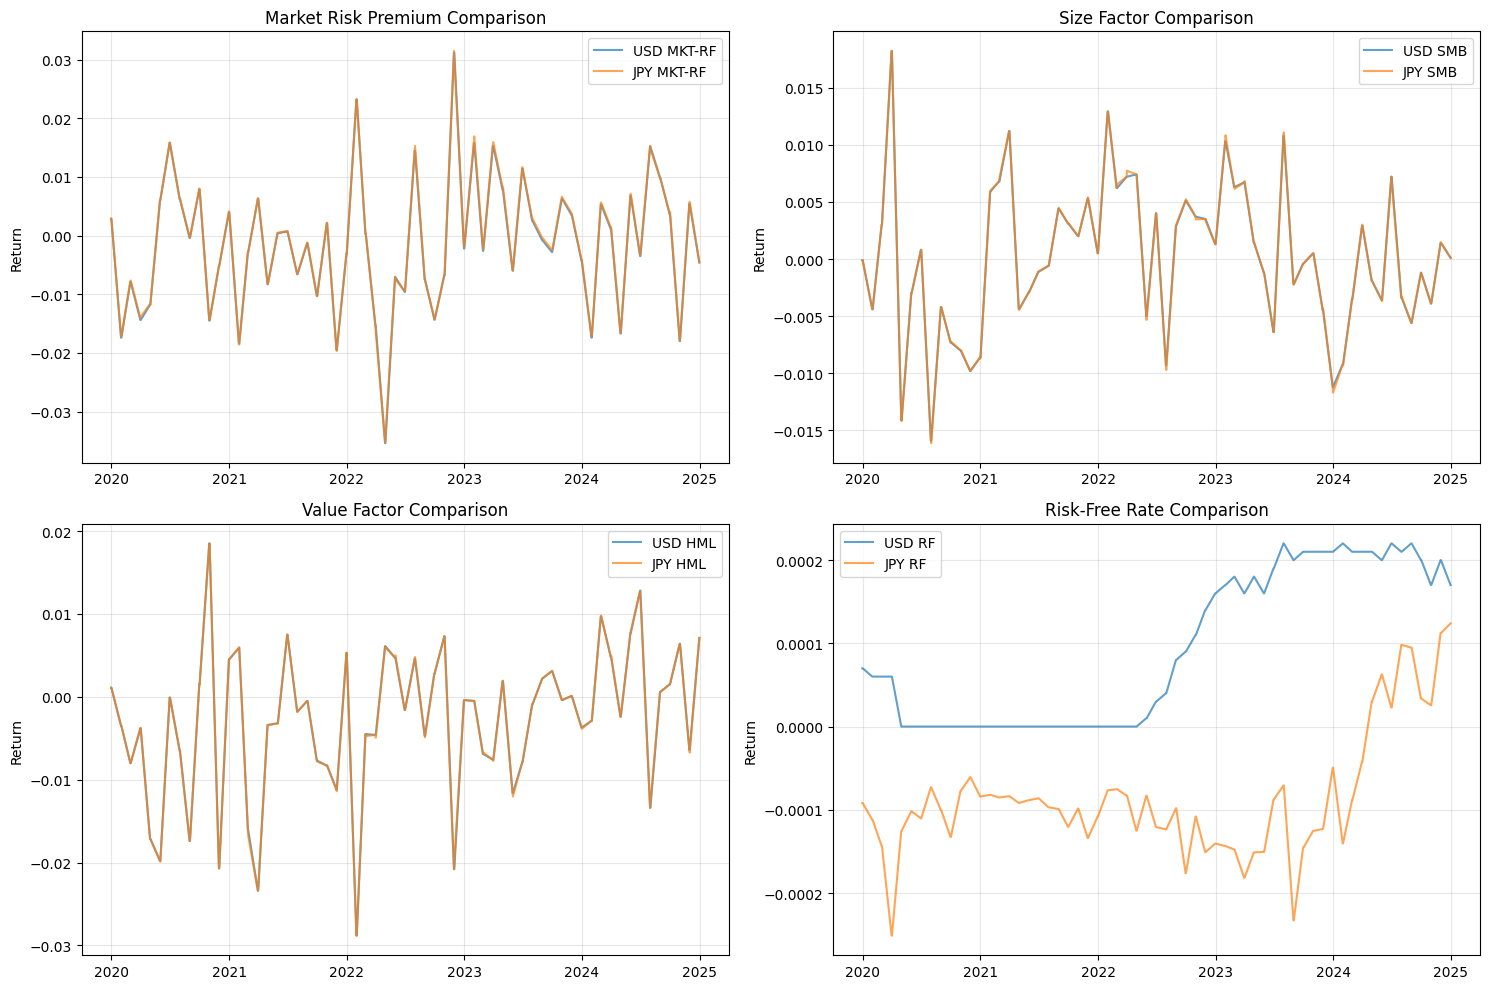

In [9]:
# 結果の可視化
print("\n結果の可視化...")

# 期間を指定してプロット（最新の5年間）
plot_start = combined_data.index.max() - pd.DateOffset(years=5)
plot_data = combined_data[combined_data.index >= plot_start]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# マーケットリターン比較
axes[0, 0].plot(plot_data.index, plot_data['MKT_RF'], label='USD MKT-RF', alpha=0.7)
axes[0, 0].plot(plot_data.index, plot_data['MKT_RF_JPY'], label='JPY MKT-RF', alpha=0.7)
axes[0, 0].set_title('Market Risk Premium Comparison')
axes[0, 0].set_ylabel('Return')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# サイズファクター
axes[0, 1].plot(plot_data.index, plot_data['SMB'], label='USD SMB', alpha=0.7)
axes[0, 1].plot(plot_data.index, plot_data['SMB_JPY'], label='JPY SMB', alpha=0.7)
axes[0, 1].set_title('Size Factor Comparison')
axes[0, 1].set_ylabel('Return')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# バリューファクター
axes[1, 0].plot(plot_data.index, plot_data['HML'], label='USD HML', alpha=0.7)
axes[1, 0].plot(plot_data.index, plot_data['HML_JPY'], label='JPY HML', alpha=0.7)
axes[1, 0].set_title('Value Factor Comparison')
axes[1, 0].set_ylabel('Return')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# リスクフリーレート
axes[1, 1].plot(plot_data.index, plot_data['RF_US'], label='USD RF', alpha=0.7)
axes[1, 1].plot(plot_data.index, plot_data['RF_JPY'], label='JPY RF', alpha=0.7)
axes[1, 1].set_title('Risk-Free Rate Comparison')
axes[1, 1].set_ylabel('Return')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# 統計情報の表示
print("\n統計情報:")
print("=" * 50)

# 基本統計量
stats_df = combined_data[['MKT_RF_JPY', 'SMB_JPY', 'HML_JPY', 'RF_JPY']].describe()
print("円ベース3ファクターモデルの基本統計量:")
print(stats_df)



統計情報:
円ベース3ファクターモデルの基本統計量:
       MKT_RF_JPY       SMB_JPY     HML_JPY      RF_JPY
count  358.000000  3.580000e+02  358.000000  359.000000
mean    -0.000548 -1.639164e-04   -0.001341   -0.000051
std      0.010048  5.571263e-03    0.006748    0.000115
min     -0.035275 -1.611007e-02   -0.028817   -0.000350
25%     -0.005664 -3.584704e-03   -0.004364   -0.000133
50%     -0.000661 -5.556712e-07   -0.000900   -0.000077
75%      0.004110  3.616919e-03    0.002237    0.000063
max      0.044312  1.820000e-02    0.022855    0.000124


In [11]:
# 相関行列
print("\n相関行列:")
correlation_matrix = combined_data[['MKT_RF_JPY', 'SMB_JPY', 'HML_JPY', 'RF_JPY']].corr()
print(correlation_matrix)



相関行列:
            MKT_RF_JPY   SMB_JPY   HML_JPY    RF_JPY
MKT_RF_JPY    1.000000  0.126892 -0.121160 -0.021952
SMB_JPY       0.126892  1.000000 -0.097728 -0.058926
HML_JPY      -0.121160 -0.097728  1.000000  0.098860
RF_JPY       -0.021952 -0.058926  0.098860  1.000000


In [12]:
# 結果の保存
print("\n結果を保存中...")

# 円ベースの3ファクターモデルデータを保存
jpy_factors = combined_data[['MKT_RF_JPY', 'SMB_JPY', 'HML_JPY', 'RF_JPY']].copy()
jpy_factors.columns = ['MKT_RF', 'SMB', 'HML', 'RF']
jpy_factors.to_csv('../data/jpy_three_factor_model.csv')

print("円ベース3ファクターモデルを '../data/jpy_three_factor_model.csv' に保存しました")

# 詳細データも保存
combined_data.to_csv('../data/three_factor_model_detailed.csv')

print("詳細データを '../data/three_factor_model_detailed.csv' に保存しました")



結果を保存中...
円ベース3ファクターモデルを '../data/jpy_three_factor_model.csv' に保存しました
詳細データを '../data/three_factor_model_detailed.csv' に保存しました


In [13]:
# データの確認
print("\n保存されたデータの確認:")
print(f"データ期間: {jpy_factors.index.min()} から {jpy_factors.index.max()}")
print(f"データ件数: {len(jpy_factors)}")
print("\n最初の5行:")
print(jpy_factors.head())
print("\n最後の5行:")
print(jpy_factors.tail())

print("\n3ファクターモデルのファクターリターン作成が完了しました！") 



保存されたデータの確認:
データ期間: 2010-01-31 00:00:00 から 2024-12-31 00:00:00
データ件数: 359

最初の5行:
              MKT_RF       SMB       HML        RF
DATE                                              
2010-01-31 -0.009805 -0.000500 -0.004200  0.000105
2010-02-01       NaN       NaN       NaN  0.000105
2010-02-28  0.001087 -0.005600  0.004000  0.000113
2010-03-01  0.001140 -0.005846  0.004176  0.000113
2010-03-31 -0.003712 -0.005100  0.002000  0.000112

最後の5行:
              MKT_RF       SMB       HML        RF
DATE                                              
2024-10-31 -0.017856 -0.003900  0.006400  0.000026
2024-11-01 -0.017591 -0.003842  0.006305  0.000026
2024-11-30  0.005488  0.001400 -0.006400  0.000112
2024-12-01  0.005783  0.001474 -0.006737  0.000112
2024-12-31 -0.004554  0.000100  0.007100  0.000124

3ファクターモデルのファクターリターン作成が完了しました！
